<a href="https://colab.research.google.com/github/TCC0226/X_ray-detection/blob/main/FaceCropping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Interruption Preventing
%%javascript
function ClickConnect(){
    console.log("Working");
    document
        .querySelector("#top-toolbar > colab-connect-button")
        .shadowRoot
        .querySelector("#connect")
        .click()
}
setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
#Imports
import cv2
import os
import random
import requests
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from glob import glob
from time import time 
import matplotlib.pyplot as plt

In [ ]:
#LINE Notify
tok = '(Replace this string with Ur API token of LINE Notify)' #LINE Notify API token
def LineNotify(token, msg = '', img_dir = ''):
    #HTTP 標頭參數與資料
    headers = {"Authorization": "Bearer " + token} #token = API token of LINE Notify
    data = {'message': '\n' + msg}  # 要發送的訊息
    files = { 'imageFile': open(img_dir, 'rb') if img_dir else None} # 要傳送的圖片檔案
    #以 requests 發送 POST 請求
    requests.post("https://notify-api.line.me/api/notify", headers = headers, data = data, files = files)

In [ ]:
#Converting sec to hr/min/sec
def time_convertion_string(s):
  string = ''
  if s//3600:
    string += f'{s//3600:2.0f} hr '
    s%=3600
  if s//60:
    string += f'{s//60:2.0f} min '
    s%=60
  string += f'{s:2.0f} sec'
  return string

time_convertion_string(12345.6789)

' 3 hr 25 min 46 sec'

In [ ]:
#Spliting train to test
start_dir = '/content/drive/MyDrive/chest_xray/asia_faces/train'
destination_dir = '/content/drive/MyDrive/chest_xray/asia_faces/test'
try:
  for dir in glob(start_dir+'/*'):
    subtime = time()
    print(f'moving {dir}...')
    for idx, dirdir in enumerate(glob(dir + '/*')):
      shutil.move(dirdir, os.path.join(destination_dir, dirdir.split('/')[-2], dirdir.split('/')[-1]))
      if idx == len(glob(dir + '/*'))//10:
        break
    print(f'{idx} pics moved.\t(time spended : {time_convertion_string(time()-subtime)})')

except Exception as e:
  LineNotify(tok, f'{type(e).__name__} : {str(e)}')
  print(f'{type(e).__name__} : {str(e)}')

moving /content/drive/MyDrive/chest_xray/asia_faces/train/normalF...
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F734.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F342.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F343.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F344.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F345.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F346.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F568.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F384.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F385.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F555.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F351.jpg
	 /content/drive/MyDrive/chest_xray/asia_faces/test/normalF/normal_F350.jpg
	 /content/drive/My

In [ ]:
# Directions Setting
input_dir = "/content/drive/MyDrive/chest_xray/asia_faces" #Face to crop 
output_dir = "/content/drive/MyDrive/chest_xray/Cropped_asia_faces" #Cropped pics are saved to here!
face_cascade0 = cv2.CascadeClassifier("/content/drive/MyDrive/chest_xray/haarcascade_frontalface_alt_tree.xml")# Face detector of OpenCV
face_cascade1 = cv2.CascadeClassifier('/content/drive/MyDrive/chest_xray/haarcascade_frontalface_alt.xml')
face_cascade2 = cv2.CascadeClassifier('/content/drive/MyDrive/chest_xray/haarcascade_frontalface_alt2.xml')
face_cascade3 = cv2.CascadeClassifier('/content/drive/MyDrive/chest_xray/haarcascade_frontalface_default.xml')
face_cascades = [globals()['face_cascade'+str(i)] for i in range(1,5)]

In [ ]:
#Finding best face cascade
itime = time()
try:
  for idx, face_cascade in enumerate(face_cascades):
    no_face = []
    subtime = time()

    for idxx, file in enumerate(glob(input_dir + '/*/*.jpg')):
      if not idxx%(len(glob(input_dir + '/*/*.jpg'))//10) and idxx:
        print('【face_cascade{}】\tProcess: {:.0f}%\tTime spended : {:.0f} sec\tEstimated remaining time : {}'.format(idx+1, 100*idxx/len(glob(input_dir + '/*/*.jpg')), time()-subtime, time_convertion_string((time()-subtime)*(10-idxx/(len(glob(input_dir + '/*/*.jpg'))//10)))))
        subtime = time()
      if not os.path.exists(os.path.join(output_dir, str(file.split('/')[-2:]).split('.')[0])+'_cropped.jpg'):
        image = load_img(os.path.join(input_dir, file))     
        image = np.array(image) # To NumPy Arrray
        img2show = image
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # 將圖像色彩空間轉換為BGR    
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 將圖像轉換為灰度圖像 (for detection)    
        faces = face_cascade.detectMultiScale(gray, 1.3, 5) # 偵測圖像中的所有人臉
        if  not len(faces):
          no_face.append(file)

    if no_face:    
      LineNotify(tok, f"\n【face_cascade{idx+1}】\nCan't find any face at {len(no_face)} pics in {len(glob(input_dir + '/*/*.jpg'))} pics. losing rate = {100*len(no_face)/len(glob(input_dir + '/*/*.jpg')):.2f}%")
      print(f"【face_cascade{idx+1}】\nCan't find any face at {len(no_face)} pics in {len(glob(input_dir + '/*/*.jpg'))} pics. losing rate = {100*len(no_face)/len(glob(input_dir + '/*/*.jpg')):.2f}%")
      # print('Couldn\'t find face in following pictures:')
      # for pic_dir in no_face:
      #   print(pic_dir)
    else:
      LineNotify(tok, f"【face_cascade{idx+1}】\nFound at least a face from each pics! ^0^")
      print(f"【face_cascade{idx+1}】\nFound at least a face from each pics! ^0^") 

except Exception as e:
  LineNotify(tok, f'{type(e).__name__} : {str(e)}')

print('Totally time spended : ',time_convertion_string(time()-itime))

【face_cascade1】 Process: 10%	Time spended : 68.57 sec	Estimated remaining time : 10 min 17 sec
【face_cascade1】 Process: 20%	Time spended : 69.21 sec	Estimated remaining time :  9 min 14 sec
【face_cascade1】 Process: 30%	Time spended : 69.28 sec	Estimated remaining time :  8 min  5 sec
【face_cascade1】 Process: 40%	Time spended : 73.31 sec	Estimated remaining time :  7 min 20 sec
【face_cascade1】 Process: 50%	Time spended : 72.51 sec	Estimated remaining time :  6 min  3 sec
【face_cascade1】 Process: 60%	Time spended : 77.92 sec	Estimated remaining time :  5 min 12 sec
【face_cascade1】 Process: 70%	Time spended : 93.65 sec	Estimated remaining time :  4 min 41 sec
【face_cascade1】 Process: 80%	Time spended : 74.99 sec	Estimated remaining time :  2 min 30 sec
【face_cascade1】 Process: 90%	Time spended : 78.53 sec	Estimated remaining time :  1 min 19 sec
【face_cascade1】 Process: 100%	Time spended : 82.10 sec	Estimated remaining time :  0 sec
【face_cascade1】
Can't found any face at 3566 pics in 479

【haarcascade_frontalface_alt_tree.xml】
Can't find any face at 3566 pics in 4793 pics. (losing rate = 74.40%)\
【haarcascade_frontalface_alt.xml】
Can't find any face at 496 pics in 4793 pics. (losing rate = 10.35%)\
【haarcascade_frontalface_alt2.xml】
Can't find any face at 459 pics in 4793 pics. (losing rate = 9.58%)\
【haarcascade_frontalface_default.xml】
Can't find any face at 410 pics in 4793 pics. (losing rate = 8.55%)


In [ ]:
best_face_cascade_idx = 3

img name :  beauty_M564.jpg


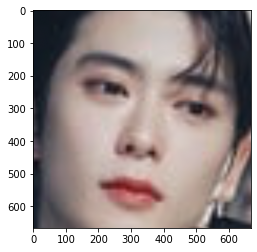

In [ ]:
#Cropping a random pic and showing
all_img = glob(input_dir + '/*/*/*')
img_dir = random.choice(all_img)
image = load_img(img_dir)
image = np.array(image) # To NumPy Arrray
img2show = image # 將圖像色彩空間轉換為BGR 
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 將圖像轉換為灰度圖像 (for detection)    
faces = face_cascades[best_face_cascade_idx].detectMultiScale(gray, 1.3, 5)

print('img name : ', img_dir.split('/')[-1])
if len(faces):
  for (x, y, w, h) in faces:
    plt.imshow(img2show[y:y+h, x:x+w]/255.) # 裁切人臉  
else:
  print(f'Face not found!')

In [ ]:
#Cropping & Saving
itime = time()

try:
  no_face = []
  subtime = time()
  for idxx, file in enumerate(glob(input_dir + '/*/*/*')):
    if not idxx%(len(glob(input_dir + '/*/*/*'))//10) and idxx:
      print('【best_face_cascade】\tProcess: {:.0f}%\tTime spended : {:.0f} sec\tEstimated remaining time : {}'.format(100*idxx/len(glob(input_dir + '/*/*/*')), time()-subtime, time_convertion_string((time()-subtime)*(10 - idxx/(len(glob(input_dir + '/*/*/*'))//10)))))
      subtime = time()
    if not os.path.exists(os.path.join(output_dir, file.split('/')[-3], file.split('/')[-2], file.split('/')[-1].split('.')[-2])+'_cropped.jpg'):
      image = load_img(os.path.join(input_dir, file))     
      image = np.array(image) # To NumPy Arrray
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # 將圖像色彩空間轉換為BGR    
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 將圖像轉換為灰度圖像 (for detection)    
      faces = face_cascades[best_face_cascade_idx].detectMultiScale(gray, 1.3, 5) # 偵測圖像中的所有人臉

      if len(faces):
        for (x, y, w, h) in faces:
          face = image[y:y+h, x:x+w] # 裁切人臉  
          cv2.imwrite(os.path.join(output_dir, file.split('/')[-3], file.split('/')[-2], file.split('/')[-1].split('.')[-2])+'_cropped.jpg', face) # 將裁切後的人臉保存至輸出資料夾
          #print('{} img saved.'.format(os.path.join(output_dir, file.split('/')[-3], file.split('/')[-2], file.split('/')[-1].split('.')[-2])+'_cropped.jpg'))
      else:
        no_face.append(file)

  if no_face:    
    print('Couldn\'t find any face in following pics:')
    for pic_dir in no_face:
      print(pic_dir)
    while "Pikas san sugoiine":
      try:
        ck_del = input('\nWanna delete all?(y\\n)').lower()
        if ck_del not in ['y','yes']+['n','no']:
          print('Please reply appropriately!')
        else:
          break
      except Exception as e:
          print(type(e).__name__," : ",str(e))
    if ck_del in ['y','yes']:
      for pic_dir in no_face:
        os.remove(pic_dir)
      print('Deleted.')

except Exception as e:
  #LineNotify(tok, f'{type(e).__name__} : {str(e)}')
  print(f'{type(e).__name__} : {str(e)}')
  raise
print('Totally time spended : ',time_convertion_string(time()-itime))

【best_face_cascade】	Process: 10%	Time spended : 64 sec	Estimated remaining time :  9 min 37 sec
【best_face_cascade】	Process: 20%	Time spended : 83 sec	Estimated remaining time : 11 min  5 sec
【best_face_cascade】	Process: 30%	Time spended : 83 sec	Estimated remaining time :  9 min 39 sec
【best_face_cascade】	Process: 40%	Time spended : 89 sec	Estimated remaining time :  8 min 53 sec
【best_face_cascade】	Process: 50%	Time spended : 86 sec	Estimated remaining time :  7 min 11 sec
【best_face_cascade】	Process: 60%	Time spended : 90 sec	Estimated remaining time :  6 min  2 sec
【best_face_cascade】	Process: 70%	Time spended : 119 sec	Estimated remaining time :  5 min 58 sec
【best_face_cascade】	Process: 80%	Time spended : 87 sec	Estimated remaining time :  2 min 55 sec
【best_face_cascade】	Process: 90%	Time spended : 98 sec	Estimated remaining time :  1 min 38 sec
Couldn't find any face in following pics:
/content/drive/MyDrive/chest_xray/asia_faces/test/beautifulM/beauty_M150.jpg
/content/drive/M

In [ ]:
#Giving Scores
max_score = 10 #score up-limit
img_dirs = glob(input_dir + '/*/*')
random.shuffle(img_dirs) #Shuffling
idx = 0 #Question No.

for file in img_dirs:
  
  image = load_img(os.path.join(input_dir, file)) #Loading pic.
  image = np.array(image) # To NumPy Arrray
  img2show = image
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # 將圖像色彩空間轉換為BGR    
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 將圖像轉換為灰度圖像 (for detection)    
  faces = face_cascades[best_face_cascade_idx].detectMultiScale(gray, 1.3, 5) # 偵測圖像中的所有人臉
  
  if len(faces): #Condition of finding face
      print('\nPic '+str(idx) if idx else '【Sample Pic】')
      for (x, y, w, h) in faces:
        face = img2show[y:y+h, x:x+w] # Cropping face
        plt.imshow(face/255.) 
        plt.show()
        print(file, ':') #Print picture name
        if idx:
          while 'Pikas is handsome':   
            try:
              ans = int(input(f'Score (0~{max_score}) : ')) #Give a score
              if 0<=ans<=max_score:
                break
              else:
                raise ValueError('The score must be 0 to', max)
                
            except Exception as e:
              print(type(e).__name__," : ",str(e))
        else:
          print(f'Score (0~{max_score}) : 4 (Enter a score.)')

  elif idx: #Condition of  not finding face
    plt.imshow(img2show/255.) 
    plt.show()
    while 'PPP':
      try:
        ck_face = input('There\'s no face in {}!\nIs it ok to delete it?(y\\n)'.format(file)).lower()
        if ck_face not in ['y','yes']+['n','no']:
          raise ValueError('Please reply appropriately!')
        else:
          break
      except Exception as e:
        print(type(e).__name__," : ",str(e))
    if ck_face in ['y','yes']:
      os.remove(file)
      print(file, ' deleted.')
  else: #Condition of not finding face while giving sample
    idx-=1

  idx += 1